In [4]:
# Basic setting
"""
이 세팅은 XGboost의 데이터셋을 이용해 CNN을 사용하는 모델입니다.
데이터 셋은 총 9990개의 샘플이 있고, 28개의 오디오 특징을 평균과 분산 추출한 데이터가 있습니다.
따라서 이 평균과 분산을 이용해 정규분포 확률밀도 모델을 사용해 데이터를 재가공한 뒤,
그것을 이미지화 시켜 CNN을 시킵니다.

<이 모델의 특징>
재가공시 확률밀도 모델을 사용합니다. 이때 X 도메인인은 0~50까지 정수로 이뤄져있습니다.
따라서 평균이 0~50을 넘어가는 경우 함수의 일부가 짤립니다.
"""

from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

DATASET_PATH = 'Data/features_3_sec.csv'

In [5]:
FEATURES = ['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth', 'rolloff',
        'zero_crossing_rate', 'harmony', 'perceptr', 'mfcc1','mfcc2', 'mfcc3', 'mfcc4',
        'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13',
        'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']

eps = np.finfo(float).eps

num_features = 29
resolution = 2
feature_resolution = num_features*resolution

np.random.seed(0)  # 0 대신 원하는 숫자를 넣으세요.

In [6]:
def load_data(data_path):
    df = pd.read_csv(data_path)

    print("Data succesfully loaded!")
    df.head()

    return  df

In [7]:
def showing_all_graph(X, row=7, col=4):
    # showing the all graphs of audio features
    
    fig1, axs = plt.subplots(row, col, figsize=(15, 20))  # Update 'row' and 'col' here as well
    # row = 1: (10,3) # row = 2: (10,3) # row = 7: (15,20)
    axs = axs.ravel()   # Flatten the grid to easily iterate over it
    nd_x = np.linspace(0, feature_resolution, feature_resolution)

    for i in range(row*col):
        axs[i].plot(nd_x, X[0][i*resolution])
        axs[i].set_title(FEATURES[i])   # Give each subplot a title for clarity

    fig1.tight_layout()   # Adjust subplot parameters to give specified padding
    # plt.savefig("All Features", dpi=300)
    plt.show()

In [8]:
def showing_map(X, color = 1):
    # showing heat map
    plt.figure(figsize=(10,7))
    if color == 0:
        plt.imshow(X, cmap='gray', interpolation='nearest')
        plt.title('Heatmap of audio Features')
    else:
        plt.imshow(X, cmap='coolwarm', interpolation='nearest')
        plt.title('Heatmap of audio Features')
    plt.colorbar(label='Values')
    plt.xlabel('value')
    plt.ylabel('Features')
    if "tempo" not in FEATURES: FEATURES.append("tempo")

    plt.yticks(np.arange(0, feature_resolution, 2), FEATURES) 

    # plt.savefig("Heat map", dpi=300)
    plt.show()
    if "tempo" in FEATURES: FEATURES.remove("tempo")

In [9]:
def plot_history(history, title = "Training History"):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """
    fig, axs = plt.subplots(2)

    if title == "Training History": val_label_acc = "validation accuracy"; val_label_err = "validation error"; title_name = "History graph(Training)";
    else: val_label_acc = "test accuracy"; val_label_err = "test error"; title_name = "History graph(Testing)";

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label=val_label_acc)
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label=val_label_err)
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    # set the overall title for all subplots
    fig.suptitle(title)
    plt.subplots_adjust(hspace = 0.5)

    plt.savefig(title_name, dpi=150)
    plt.show()

In [10]:
def predict(model, X, y):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [86]:
def add_noise(input):
    # it can add noise on the heatmap, but I did not use it
    image = np.ones((feature_resolution, feature_resolution))

    noise_filter = np.random.normal(0, 0.02, image.shape)

    noisy_image = input + noise_filter

    noisy_image = np.clip(noisy_image, 0., 1.)

    return noisy_image

# example = np.zeros((feature_resolution, feature_resolution))
# ex = add_noise(example)
# showing_map(ex, 1)

In [70]:
# load data
df = load_data(DATASET_PATH)

for i in FEATURES: # normalize all features
  diff = np.max(df['{}_mean'.format(i)]) - np.min(df['{}_mean'.format(i)]) + eps
  df['{}_mean'.format(i)] -= np.min(df['{}_mean'.format(i)])
  df['{}_mean'.format(i)] /= diff

row_dicts = df.to_dict('records')

Data succesfully loaded!


In [71]:
# preprocessing x ------------------------------------------------------------------------------------------------------
X = []; tempo_list = df['tempo']
tempo_list /= np.max(tempo_list) - np.min(tempo_list) + eps # normalize Tempo
nd_x = np.linspace(0, feature_resolution, feature_resolution)

for i in range(len(row_dicts)):
    X.append([])
    for j in FEATURES:
        mu = row_dicts[i]['{}_mean'.format(j)]
        sigma = np.sqrt(row_dicts[i]['{}_var'.format(j)])

        for _ in range(resolution):
            # nd_y = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp( - np.round(nd_x - mu*feature_resolution - _)**2 / (2 * sigma**2) ) # normal distribution
            nd_y = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp( - (nd_x - np.round(mu*feature_resolution) - _)**2 / (2 * sigma**2) ) # normal distribution

            # normalize
            diff = np.max(nd_y) - np.min(nd_y) + eps # diff가 0이 되는걸 방지하기 위해 아주 작은 상수 엡실론 (eps)를 더합니다.
            normalized_nd_y = (nd_y - np.min(nd_y)) / diff
            normalized_nd_y *= 10

            X[-1].append(normalized_nd_y)

    tempo = np.ones(feature_resolution)*tempo_list[i]*10
    for _ in range(resolution):
        X[-1].append(tempo)

    # add noise
    # X[-1] = add_noise(X[-1])

X = np.array(X)

In [72]:
 # preprocessing y ------------------------------------------------------------------------------------------------------
y = df['label']
y = pd.get_dummies(y)
y = np.array(y)

print('Finish to make X, y!')

Finish to make X, y!


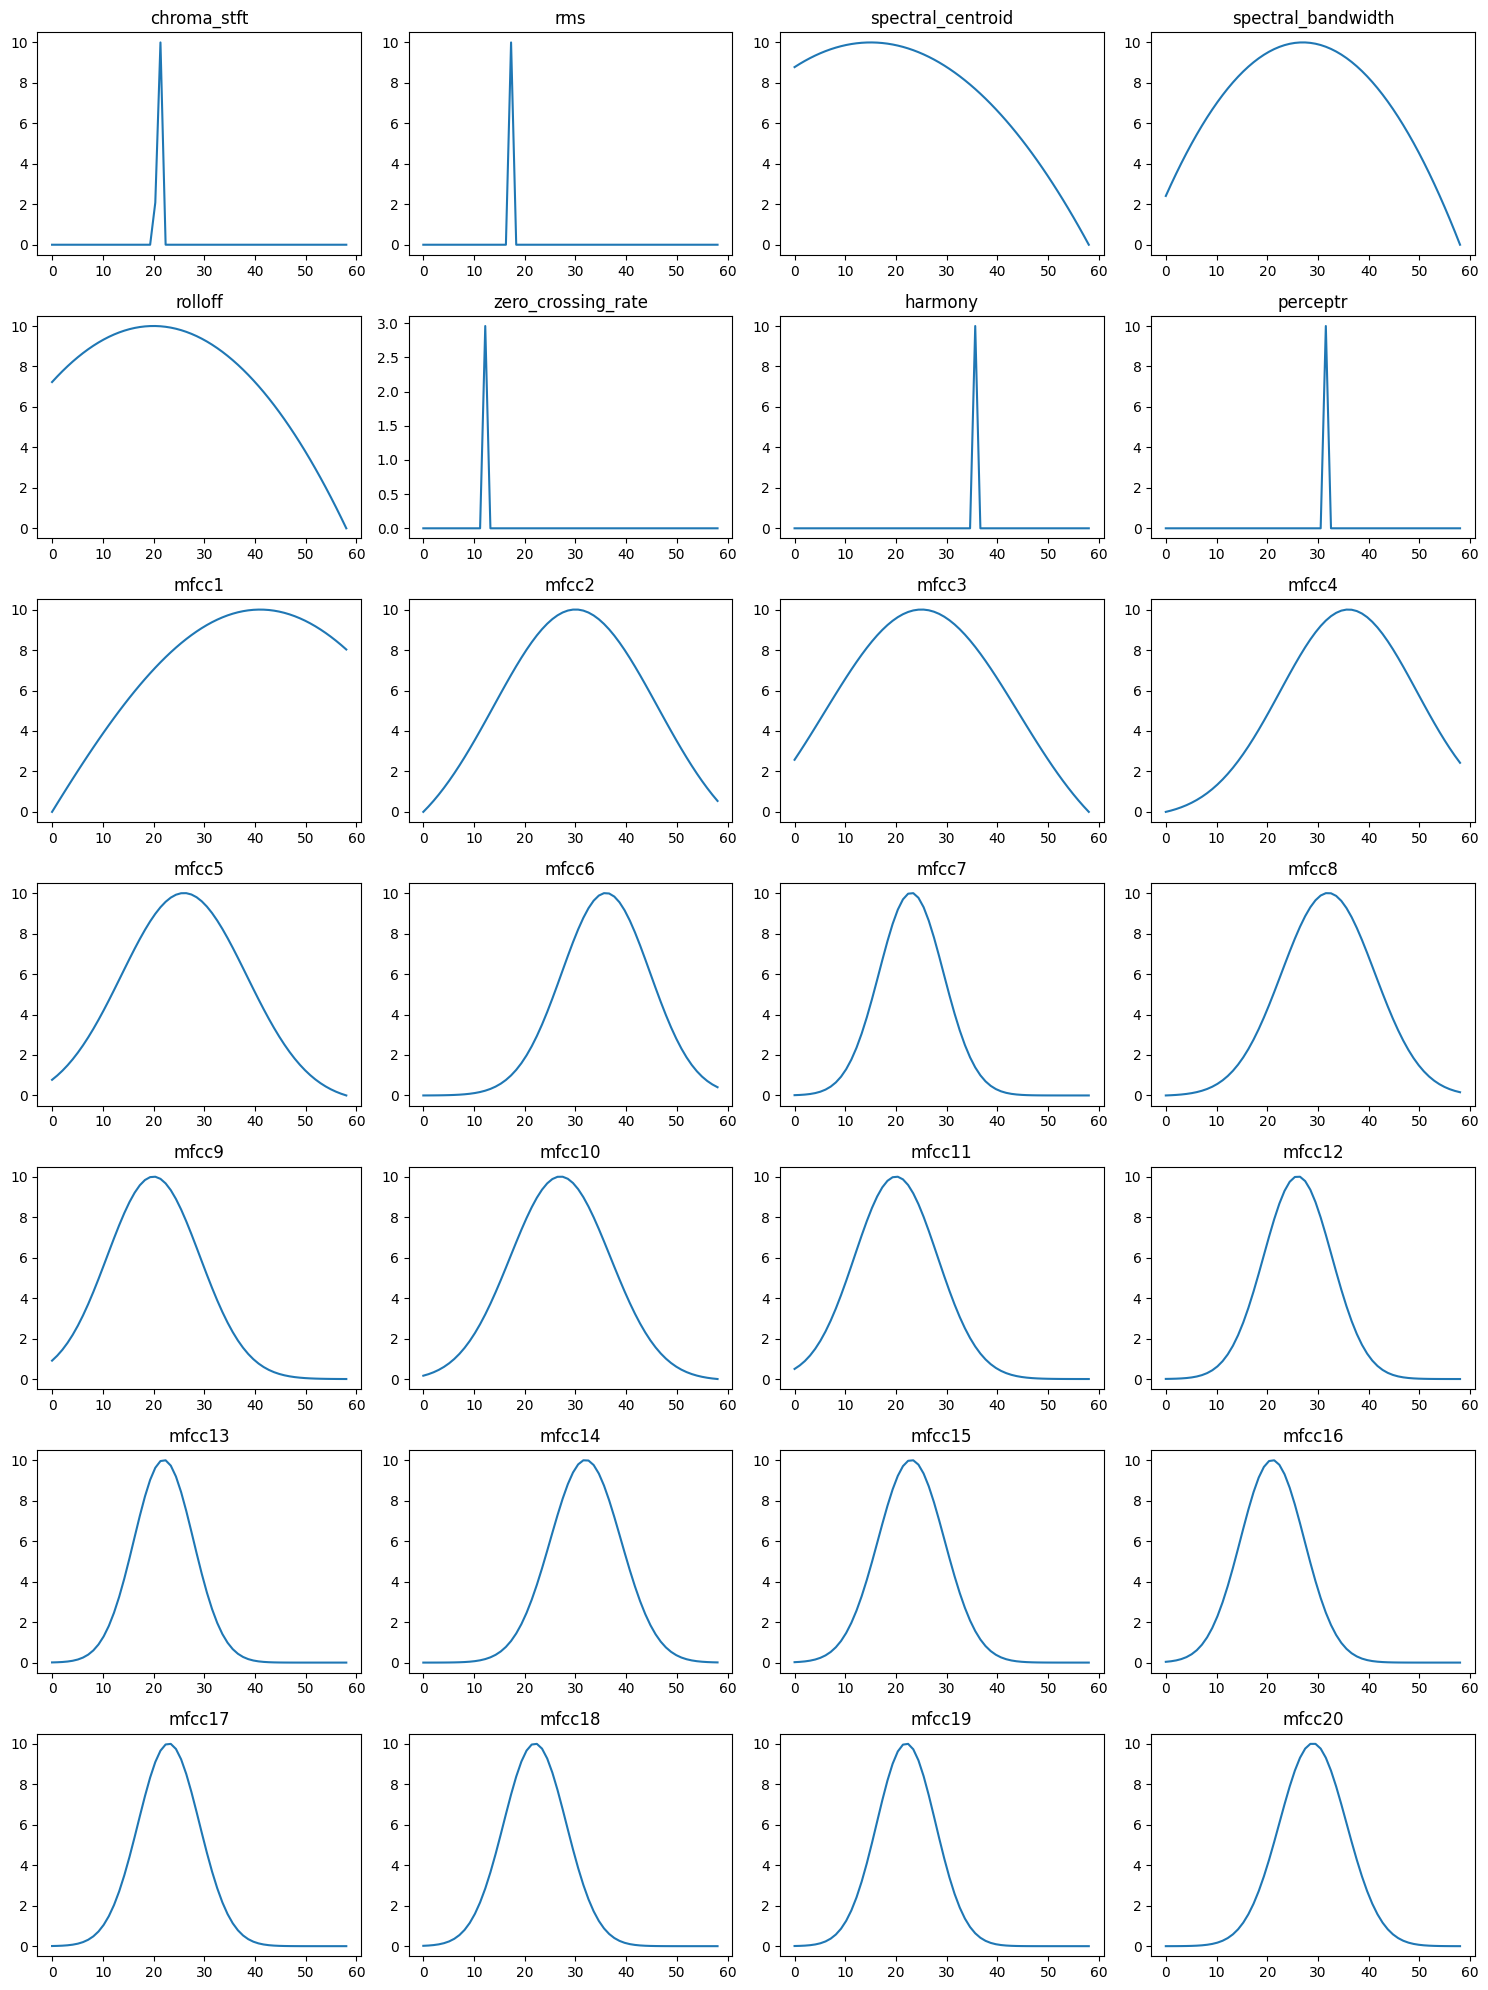

In [73]:
# Showing the normal distribution of all features
showing_all_graph(X)

In [74]:
# make a training, validation and test set
test_size = 0.2
validation_size = 0.2

# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)

# create train/validation split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size, stratify=y_train)

X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]
# 4d array -> (num_sample, 28, 50, 1)

print('Finish to make training set!')

Finish to make training set!


In [75]:
print(X.shape)
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

(9990, 58, 58)
(6393, 58, 58, 1)
(1599, 58, 58, 1)
(1998, 58, 58, 1)


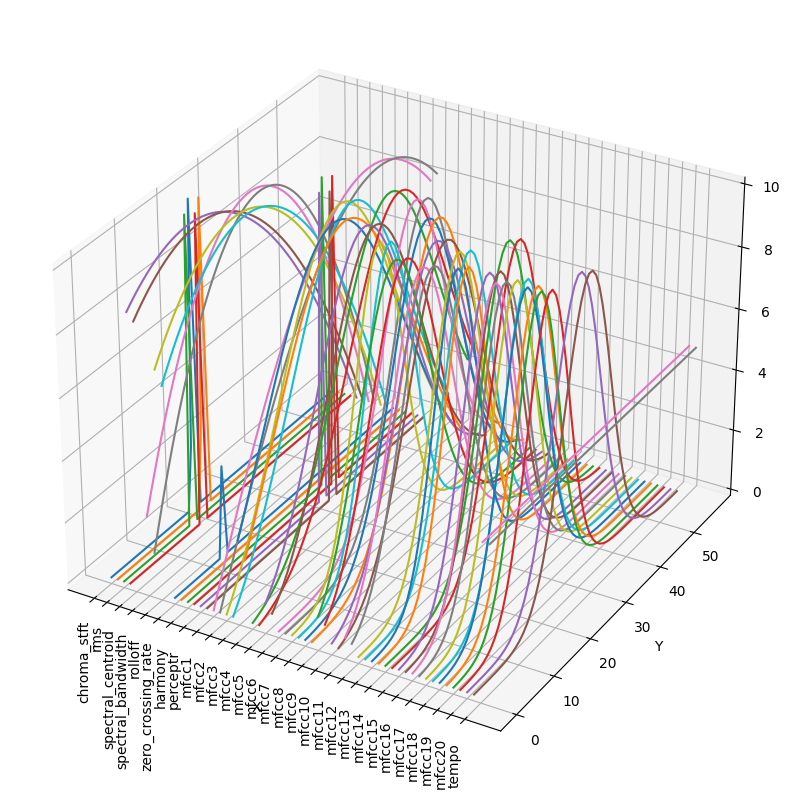

In [18]:
# Showing the features in 3D
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

for i in range(feature_resolution):
  x = np.ones(feature_resolution)*i
  y = np.arange(feature_resolution)
  z = X[0][i][y]
  ax.plot3D(x, y, z)
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

if "tempo" not in FEATURES: FEATURES.append("tempo")

ax.set_xticks(np.arange(0, feature_resolution, 2))
ax.set_xticklabels(FEATURES, rotation=90)

# plt.savefig("data 3D", dpi=300)
plt.show() 
if "tempo" in FEATURES: FEATURES.remove("tempo")

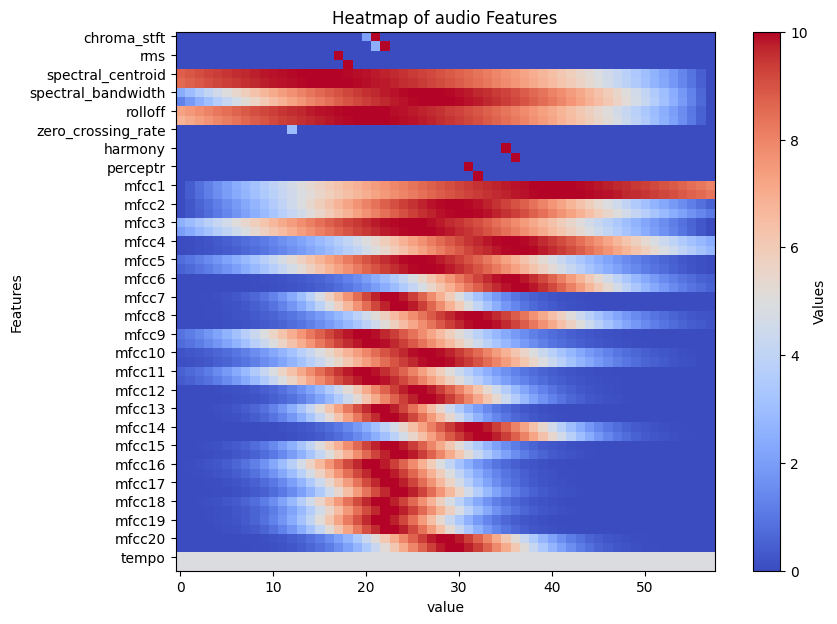

In [19]:
# showing heat map
showing_map(X[0])

In [33]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, AveragePooling2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers.legacy import Adam, Nadam, RMSprop, SGD, Adagrad, Adadelta, Adamax

# Making LeNet5 model
def create_model(optimizer = Adamax(learning_rate=0.001), active = 'swish'):
    model_X = Input(shape=[feature_resolution, feature_resolution, 1])

    # Convolution layer
    H = ZeroPadding2D(padding=1)(model_X)
    H = Conv2D(6, kernel_size=3, activation=active)(H)
    H = AveragePooling2D(pool_size=2, strides=2)(H)
    H = BatchNormalization()(H)

    H = Conv2D(16, kernel_size=3, activation=active)(H)
    H = AveragePooling2D(pool_size=2, strides=2)(H)
    H = BatchNormalization()(H)

    # Fully connected layer
    H = Flatten()(H)

    H = Dropout(0.5)(H)
    H = Dense(120, activation='relu')(H)
    H = BatchNormalization()(H)

    H = Dense(84, activation='relu')(H)
    H = BatchNormalization()(H)

    model_Y = Dense(10, activation='softmax')(H)

    model = Model(model_X, model_Y)

    # compile model
    model.compile(loss='categorical_crossentropy', metrics='accuracy', optimizer=optimizer)

    return model

In [23]:
# GridSearch for Optimizer
opt = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
epochs = [10, 50, 100]
results1 = []

for optimizer in opt:
    for epoch in epochs:
        model = create_model(optimizer=optimizer)
        print(optimizer)
        history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=40, epochs=epoch)
        val_acc = history.history['val_accuracy'][-1]
        results1.append({'optimizer': optimizer, 'epochs': epoch, 'val_acc': val_acc})

# Sorting
results1.sort(key=lambda x: x['val_acc'], reverse=True)

SGD
Epoch 1/10
160/160 [==============================] - 3s 15ms/step - loss: 1.8811 - accuracy: 0.3659 - val_loss: 1.5889 - val_accuracy: 0.4772
Epoch 2/10
160/160 [==============================] - 2s 15ms/step - loss: 1.3858 - accuracy: 0.5206 - val_loss: 1.2911 - val_accuracy: 0.5654
Epoch 3/10
160/160 [==============================] - 2s 15ms/step - loss: 1.2164 - accuracy: 0.5712 - val_loss: 1.0812 - val_accuracy: 0.6385
Epoch 4/10
160/160 [==============================] - 2s 15ms/step - loss: 1.1393 - accuracy: 0.6046 - val_loss: 1.1062 - val_accuracy: 0.6148
Epoch 5/10
160/160 [==============================] - 2s 15ms/step - loss: 1.0601 - accuracy: 0.6258 - val_loss: 0.9433 - val_accuracy: 0.6623
Epoch 6/10
160/160 [==============================] - 3s 17ms/step - loss: 1.0046 - accuracy: 0.6506 - val_loss: 1.1084 - val_accuracy: 0.6248
Epoch 7/10
160/160 [==============================] - 2s 15ms/step - loss: 0.9510 - accuracy: 0.6718 - val_loss: 0.8717 - val_accuracy: 0.

In [25]:
# chagne the result1 to pandas DataFrame
results_df1 = pd.DataFrame(results1)

# Sorting
results_df1 = results_df1.sort_values(by='val_acc', ascending=False)
pd.DataFrame(results1)
# results_df.to_csv('results.csv', index=False)

,optimizer,epochs,val_acc
0,Adamax,100,0.887430
1,RMSprop,100,0.878049
2,Nadam,100,0.877423
3,SGD,100,0.876798
4,Adamax,50,0.876798
5,RMSprop,50,0.866792
6,SGD,50,0.865541
7,Adam,100,0.864916
8,Adam,50,0.863039
9,Nadam,50,0.858036


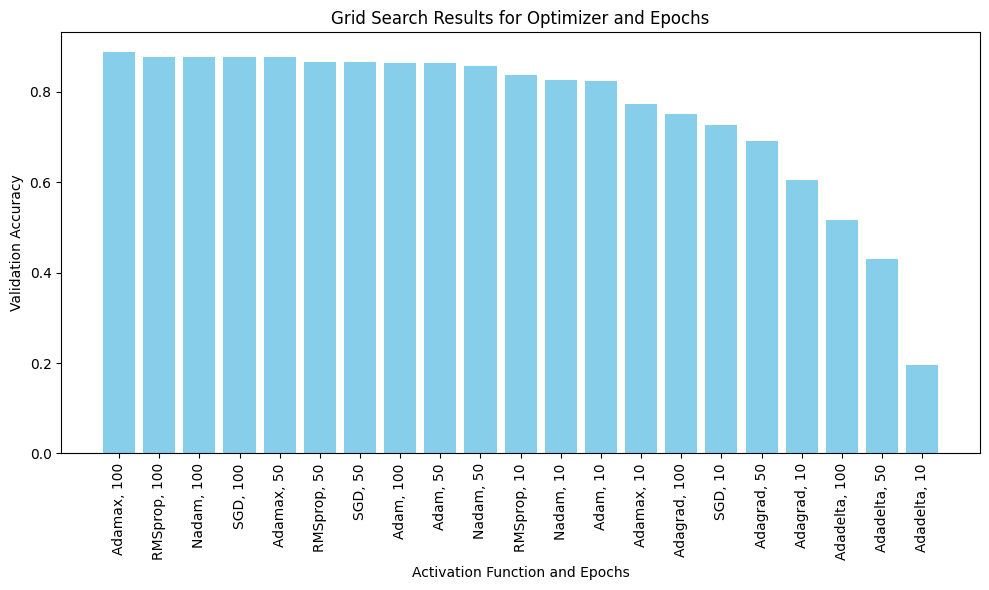

In [26]:
# Showing the raking of the result with bar graph
results_df1['label'] = results_df1['optimizer'] + ', ' + results_df1['epochs'].astype(str)

labels = results_df1['label']
val_acc = results_df1['val_acc']

plt.figure(figsize=(10, 6))
plt.bar(labels, val_acc, color='skyblue')
plt.title('Grid Search Results for Optimizer and Epochs')
plt.ylabel('Validation Accuracy')
plt.xlabel('Activation Function and Epochs')
plt.xticks(rotation=90)

plt.tight_layout()

plt.savefig("Optimizer Function and Epochs", dpi=300, bbox_inches='tight')
plt.show()

In [83]:
# GridSearch for Activation
actives = ['elu', 'exponential', 'gelu', 'relu', 'sigmoid', 'softmax', 'swish', 'tanh']
epochs = [10, 50, 100]
results = []

for act in actives:
    for epoch in epochs:
        model = create_model(optimizer='Adamax', active = act)
        print(act)
        history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=40, epochs=epoch)
        val_acc = history.history['val_accuracy'][-1]
        results.append({'activation': act, 'epochs': epoch, 'val_acc': val_acc})

# Sorting
results.sort(key=lambda x: x['val_acc'], reverse=True)

elu
Epoch 1/10
160/160 [==============================] - 3s 14ms/step - loss: 1.7353 - accuracy: 0.4158 - val_loss: 1.4952 - val_accuracy: 0.5172
Epoch 2/10
160/160 [==============================] - 2s 14ms/step - loss: 1.2887 - accuracy: 0.5522 - val_loss: 1.1591 - val_accuracy: 0.5979
Epoch 3/10
160/160 [==============================] - 2s 14ms/step - loss: 1.1171 - accuracy: 0.6115 - val_loss: 0.9620 - val_accuracy: 0.6754
Epoch 4/10
160/160 [==============================] - 2s 16ms/step - loss: 1.0041 - accuracy: 0.6531 - val_loss: 0.9051 - val_accuracy: 0.6861
Epoch 5/10
160/160 [==============================] - 2s 14ms/step - loss: 0.9219 - accuracy: 0.6776 - val_loss: 0.8247 - val_accuracy: 0.7079
Epoch 6/10
160/160 [==============================] - 2s 14ms/step - loss: 0.8588 - accuracy: 0.6992 - val_loss: 0.7633 - val_accuracy: 0.7230
Epoch 7/10
160/160 [==============================] - 2s 14ms/step - loss: 0.8068 - accuracy: 0.7184 - val_loss: 0.7150 - val_accuracy: 0.

In [87]:
# chagne the result1 to pandas DataFrame
results_df = pd.DataFrame(results)

# Sorting
results_df = results_df.sort_values(by='val_acc', ascending=False)
pd.DataFrame(results)
# results_df.to_csv('results.csv', index=False)

,activation,epochs,val_acc
0,elu,100,0.894309
1,exponential,100,0.894309
2,relu,100,0.893058
3,gelu,100,0.889306
4,softmax,100,0.888055
5,sigmoid,100,0.887430
6,tanh,50,0.887430
7,sigmoid,50,0.886804
8,swish,100,0.885553
9,swish,50,0.879925


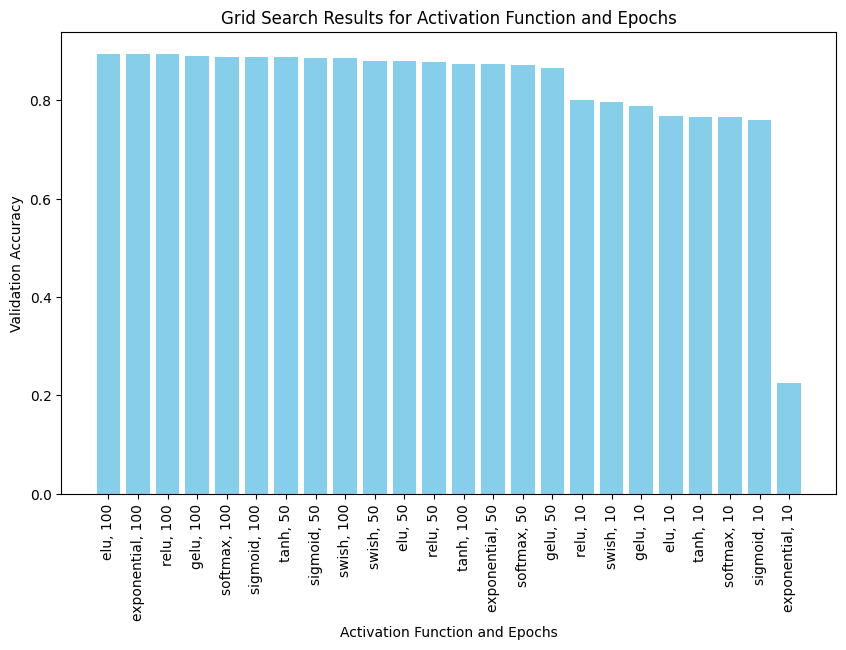

In [88]:
# Showing the raking of the result with bar graph
results_df['label'] = results_df['activation'] + ', ' + results_df['epochs'].astype(str)

labels = results_df['label']
val_acc = results_df['val_acc']

plt.figure(figsize=(10, 6))
plt.bar(labels, val_acc, color='skyblue')
plt.title('Grid Search Results for Activation Function and Epochs')
plt.ylabel('Validation Accuracy')
plt.xlabel('Activation Function and Epochs')
plt.xticks(rotation=90)

plt.savefig("Activation Function and Epochs", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
model = create_model(Adamax,'swish')

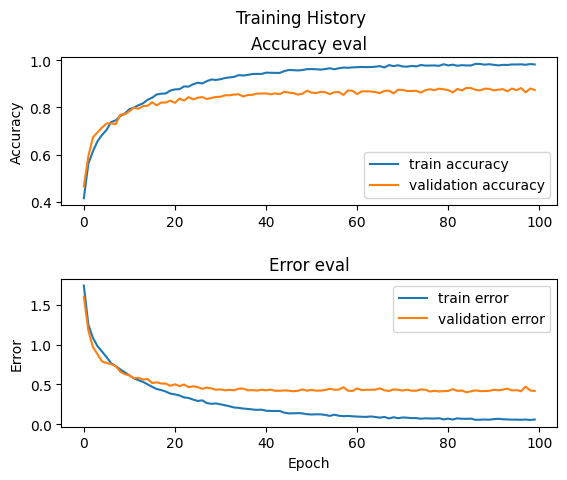

In [92]:
# plot accuracy/error for training and validation
plot_history(history, "Training History")

In [130]:
model.summary()

Model: "model_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_127 (InputLayer)      [(None, 58, 58, 1)]       0         
                                                                 
 zero_padding2d_126 (ZeroPa  (None, 60, 60, 1)         0         
 dding2D)                                                        
                                                                 
 conv2d_252 (Conv2D)         (None, 58, 58, 6)         60        
                                                                 
 average_pooling2d_252 (Ave  (None, 29, 29, 6)         0         
 ragePooling2D)                                                  
                                                                 
 batch_normalization_504 (B  (None, 29, 29, 6)         24        
 atchNormalization)                                              
                                                         

In [131]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=40, epochs=100)

Epoch 1/100
160/160 [==============================] - 3s 16ms/step - loss: 1.5941 - accuracy: 0.4616 - val_loss: 1.7397 - val_accuracy: 0.4071
Epoch 2/100
160/160 [==============================] - 3s 17ms/step - loss: 1.1373 - accuracy: 0.6064 - val_loss: 1.2516 - val_accuracy: 0.5804
Epoch 3/100
160/160 [==============================] - 3s 16ms/step - loss: 0.9924 - accuracy: 0.6506 - val_loss: 0.9204 - val_accuracy: 0.6886
Epoch 4/100
160/160 [==============================] - 3s 16ms/step - loss: 0.9018 - accuracy: 0.6926 - val_loss: 0.8597 - val_accuracy: 0.6948
Epoch 5/100
160/160 [==============================] - 3s 16ms/step - loss: 0.8266 - accuracy: 0.7158 - val_loss: 0.7556 - val_accuracy: 0.7417
Epoch 6/100
160/160 [==============================] - 3s 16ms/step - loss: 0.7648 - accuracy: 0.7386 - val_loss: 0.7157 - val_accuracy: 0.7617
Epoch 7/100
160/160 [==============================] - 3s 16ms/step - loss: 0.7353 - accuracy: 0.7427 - val_loss: 0.6834 - val_accuracy:

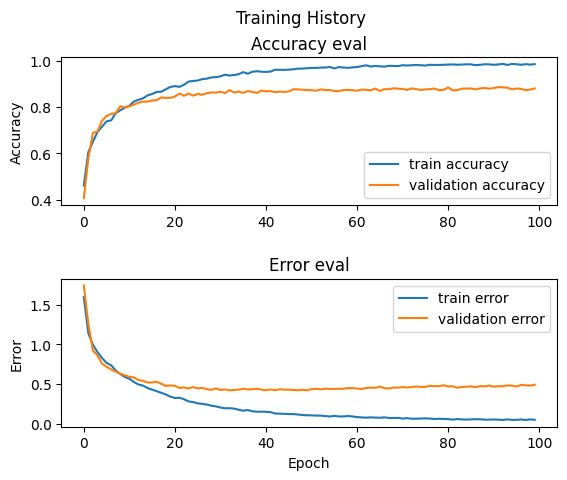

done


In [182]:
# plot accuracy/error for training and validation
plot_history(history, "Training History")

63/63 - 0s - loss: 0.1676 - accuracy: 0.9590 - 269ms/epoch - 4ms/step

Test accuracy: 0.9589589834213257
1/1 [==============================] - 0s 10ms/step
Target: [False False False False False  True False False False False], Predicted label: [5]


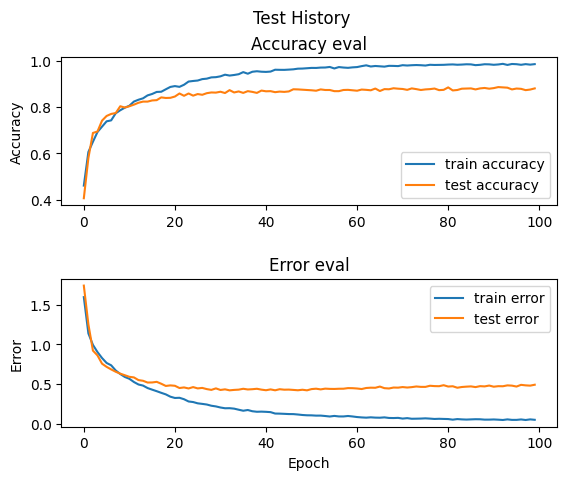

In [183]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

# predict sample
predict(model, X_to_predict, y_to_predict)

# plot accuracy and error over epochs
plot_history(history, "Test History")

63/63 [==============================] - 0s 4ms/step


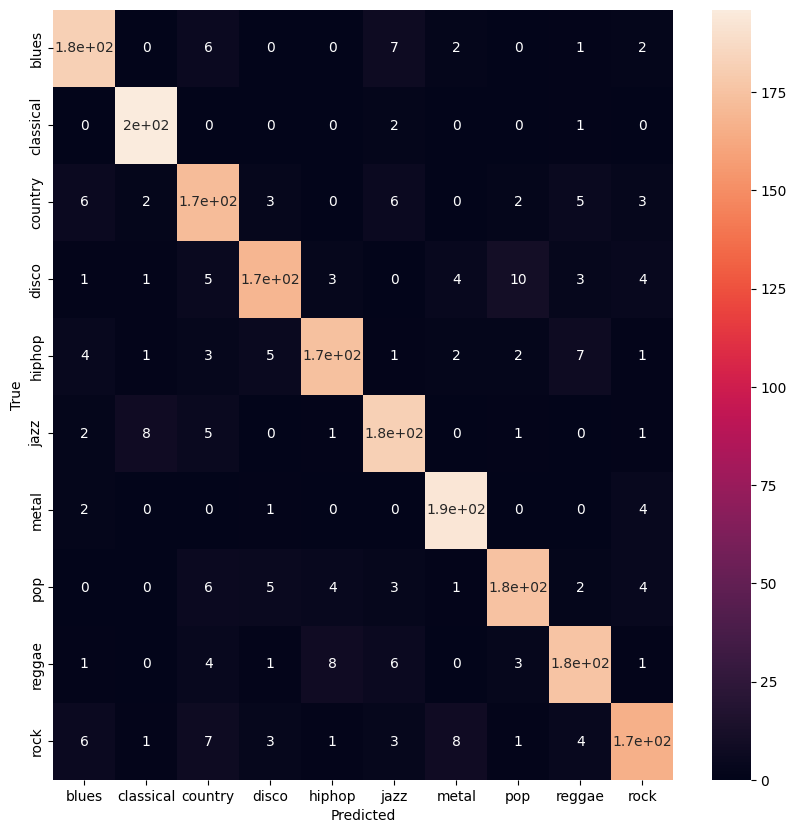

In [169]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = np.argmax(model.predict(X_test), axis=1)

y_test = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 10)) # plt.figure(figsize = (16, 9))
sns.heatmap(cm, annot=True,
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("conf matrix", dpi=300)
plt.show()

In [117]:
from sklearn.metrics import classification_report

# Compute the model's predictions
y_pred = model.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Also convert the true values to class labels
y_true = np.argmax(y_test, axis=1)

# Generate a classification report
report = classification_report(y_true, y_pred_classes)
print(report)

63/63 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.94      0.89      0.92       200
           1       0.91      0.97      0.94       199
           2       0.82      0.87      0.85       199
           3       0.86      0.89      0.88       200
           4       0.95      0.81      0.88       200
           5       0.81      0.92      0.86       200
           6       0.93      0.98      0.96       200
           7       0.92      0.90      0.91       200
           8       0.90      0.87      0.89       200
           9       0.90      0.82      0.86       200

    accuracy                           0.89      1998
   macro avg       0.89      0.89      0.89      1998
weighted avg       0.89      0.89      0.89      1998

